In [1]:
import os
import sys

top_dir = os.path.split(os.getcwd())[0]
sys.path.append(top_dir)
sys.path.append(os.path.join(top_dir, "src"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
from yaml import safe_load

%load_ext lab_black

pd.options.display.float_format = "{:.3f}".format

In [3]:
def autolabel(ax, orient="h", fmt="{:,f}", xytext=(5, -4), **kwargs):
    """Automatically labels the rectangles in a (vertical) bar chart.
    """

    for rect in ax.patches:
        if orient == "h":
            size = rect.get_width()
            xy = (size, rect.get_y())
        else:
            size = rect.get_height()
            xy = (rect.get_x() + rect.get_width() / 2, size)
        if size != 0:
            ax.annotate(
                fmt.format(size),
                xy=xy,
                xytext=xytext,
                textcoords="offset points",
                ha="center",
                va="bottom",
                **kwargs,
            )


def get_colnames(genres, metric_names):
    return [f"{name}_{genre}" for name in metric_names for genre in genres]


def build_df(results, metric_names):
    genres = results[metric_names[0]].keys()
    per_metric_dfs = []
    for genre in genres:
        per_genre_dfs = []
        for metric in metric_names:
            df = pd.DataFrame(np.array(results[metric][genre]), columns=["value"])
            df["metric"] = metric
            df["model"] = genre
            per_genre_dfs.append(df)
        per_metric_dfs.append(pd.concat(per_genre_dfs, axis=0))

    return pd.concat(per_metric_dfs, axis=0)[["model", "metric", "value"]]


def split_model_name(df):
    df["train_data"] = df["model_name"].str.split("_", expand=True)[0]
    df["Sampling Rate"] = (
        df["model_name"]
        .str.split("_", expand=True)[1]
        .str.replace("fs", "")
        .astype(int)
    )
    df["# bars"] = (
        df["model_name"]
        .str.split("_", expand=True)[2]
        .str.replace("bars", "")
        .astype(int)
    )
    return df

In [4]:
# models were trained during 14th/15th of July
models = [m for m in os.listdir("../trained_models") if "07_15" in m or "07_14" in m]

# Create a map between the model train dir and the training configuration
name_map = {}
for model in models:
    base = model.split("_")[0]
    with open(f"../trained_models/{model}/train_config.yaml") as f:
        config = safe_load(f)
        fs = config["preprocessing"]["fs"]
        n_bars = config["preprocessing"]["n_bars"]
        name_map[model] = f"{base}_fs{fs}_{n_bars}bars"

In [5]:
name_map

{'jazz_run_2022_07_15-18_00_48': 'jazz_fs8_1bars',
 'jazz_run_2022_07_15-18_13_00': 'jazz_fs8_2bars',
 'jazz_run_2022_07_15-18_25_02': 'jazz_fs8_4bars',
 'jazz_run_2022_07_15-18_37_10': 'jazz_fs8_8bars',
 'jazz_run_2022_07_15-18_49_25': 'jazz_fs16_1bars',
 'jazz_run_2022_07_15-19_02_44': 'jazz_fs16_2bars',
 'jazz_run_2022_07_15-19_16_16': 'jazz_fs16_4bars',
 'jazz_run_2022_07_15-19_29_49': 'jazz_fs16_8bars',
 'jazz_run_2022_07_15-19_43_40': 'jazz_fs32_1bars',
 'jazz_run_2022_07_15-19_57_39': 'jazz_fs32_2bars',
 'jazz_run_2022_07_15-20_11_32': 'jazz_fs32_4bars',
 'jazz_run_2022_07_15-20_25_34': 'jazz_fs32_8bars',
 'pop_run_2022_07_14-21_38_58': 'pop_fs8_1bars',
 'pop_run_2022_07_14-21_53_39': 'pop_fs8_2bars',
 'pop_run_2022_07_14-22_08_38': 'pop_fs8_4bars',
 'pop_run_2022_07_14-22_23_43': 'pop_fs8_8bars',
 'pop_run_2022_07_14-22_38_26': 'pop_fs16_1bars',
 'pop_run_2022_07_14-22_54_18': 'pop_fs16_2bars',
 'pop_run_2022_07_14-23_10_31': 'pop_fs16_4bars',
 'pop_run_2022_07_14-23_25_51': 'p

In [6]:
results_fpath = "../results/bodhidharma"
nano_df = []
macro_df = []
tonnetz_df = []

# Load the results
for model_name in os.listdir(results_fpath):
    fname = os.listdir(os.path.join(results_fpath, model_name))[0]
    fpath = os.path.join(results_fpath, model_name, fname)

    with open(fpath, "r") as f:
        results = json.load(f)

    # Create dataframes
    chromas = build_df(results, ["chroma_similarities"])
    tonnetz_distances = build_df(results, ["tonnetz_distances"])
    style_macro = build_df(results, ["macro_time_pitch_diff", "macro_onset_duration"])
    style_per_song = build_df(
        results, ["per_song_time_pitch_diff", "per_song_onset_duration"]
    )

    nano_metrics = pd.concat([chromas, style_per_song], axis=0)
    nano_metrics["model_name"] = name_map.get(model_name)
    tonnetz_distances["model_name"] = name_map.get(model_name)
    style_macro["model_name"] = name_map.get(model_name)

    nano_df.append(nano_metrics[nano_metrics["model_name"].notna()])
    tonnetz_df.append(tonnetz_distances[tonnetz_distances["model_name"].notna()])
    macro_df.append(style_macro[style_macro["model_name"].notna()])

nano_df = split_model_name(pd.concat(nano_df, axis=0))
tonnetz_df = split_model_name(pd.concat(tonnetz_df, axis=0))
macro_df = split_model_name(pd.concat(macro_df, axis=0))

## Nano metrics

In [64]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator


def plot_fs(df, model):
    palette = sns.color_palette("husl", 3)
    sns.set_style("darkgrid")
    fg = sns.catplot(
        kind="box",
        x="Sampling Rate",
        y="value",
        hue="Metric",
        col="# bars",
        col_wrap=2,
        sharex=False,
        data=df,
        notch=True,
        palette=palette,
        aspect=1.2,
    )

    fg.set_axis_labels("Sampling Rate", "Cosine-Similarity")
    fg.figure.suptitle(f"ChordGAN Nano Metrics: {model}")
    fg.figure.subplots_adjust(top=0.95)
    plt.show()


def plot_n_bars(df, model):
    sns.set_style("darkgrid")
    palette = sns.color_palette("husl", 3)

    fg = sns.catplot(
        kind="box",
        x="# bars",
        y="value",
        hue="Metric",
        col="Sampling Rate",
        col_wrap=2,
        sharex=False,
        data=df,
        notch=True,
        palette=palette,
        aspect=1.3,
    )

    fg.set_axis_labels("# bars", "Cosine-Similarity")
    fg.figure.suptitle(f"ChordGAN Nano Metrics: {model}")
    fg.figure.subplots_adjust(top=0.9)
    plt.show()


def get_summary(df, model):
    nano_agg = (
        df.groupby(["train_data", "Sampling Rate", "# bars", "Metric"], as_index=False)[
            "value"
        ]
        .mean()
        .pivot_table(
            index=["train_data", "Metric"], columns=["Sampling Rate", "# bars"]
        )
    )

    if model == "jazz":
        summary = nano_agg.iloc[:3, :]
    else:
        summary = nano_agg.iloc[3:, :]
    summary = summary.reset_index().iloc[:, 2:]
    summary.index = ["Chroma-Similarity", "Onset-Duration", "Time-Pitch Difference"]
    summary.columns = summary.columns.droplevel()
    return summary


nano_map = {
    "chroma_similarities": "Chroma-Similarity",
    "per_song_time_pitch_diff": "Time-Pitch Difference",
    "per_song_onset_duration": "Onset-Duration",
}
nano_df["Metric"] = nano_df["metric"].replace(nano_map)

nano_jazz = nano_df[nano_df["model_name"].str.contains("jazz")]
nano_pop = nano_df[nano_df["model_name"].str.contains("pop")]

In [27]:
nano_agg = (
    nano_df.groupby(["Sampling Rate", "# bars", "Metric"], as_index=False)["value"]
    .mean()
    .pivot_table(index=["Metric", "Sampling Rate"], columns=["# bars"])
)
nano_agg

value                  
# bars                                  1     2     4     8
Metric                Sampling Rate                        
Chroma-Similarity     8             0.761 0.754 0.746 0.749
                      16            0.775 0.759 0.764 0.748
                      32            0.781 0.779 0.767 0.758
Onset-Duration        8             0.786 0.789 0.787 0.788
                      16            0.831 0.825 0.831 0.834
                      32            0.878 0.878 0.876 0.877
Time-Pitch Difference 8             0.776 0.774 0.770 0.777
                      16            0.824 0.814 0.819 0.819
                      32            0.840 0.838 0.838 0.831

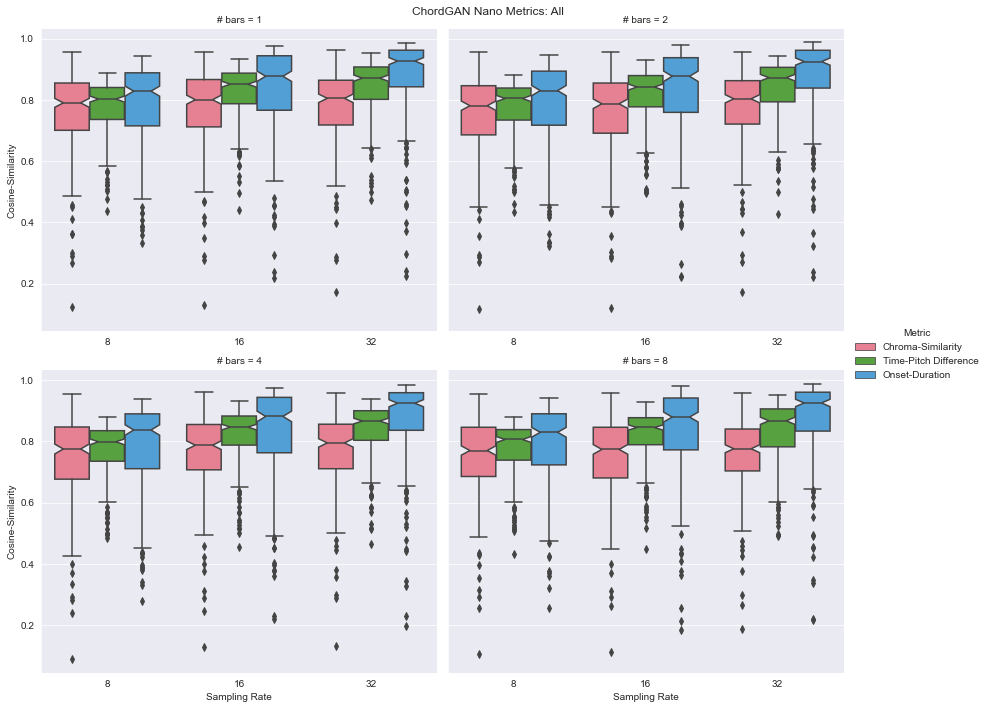

In [65]:
plot_fs(nano_df, "All")

### Jazz

In [8]:
jazz_summary = get_summary(nano_df, "jazz")
jazz_summary

Sampling Rate             8                      16                      32  \
# bars                    1     2     4     8     1     2     4     8     1   
Chroma-Similarity     0.821 0.811 0.822 0.815 0.834 0.812 0.824 0.819 0.833   
Onset-Duration        0.775 0.783 0.776 0.774 0.828 0.823 0.830 0.830 0.861   
Time-Pitch Difference 0.711 0.705 0.707 0.709 0.755 0.741 0.745 0.754 0.764   

Sampling Rate                            
# bars                    2     4     8  
Chroma-Similarity     0.832 0.829 0.799  
Onset-Duration        0.866 0.862 0.856  
Time-Pitch Difference 0.761 0.766 0.740

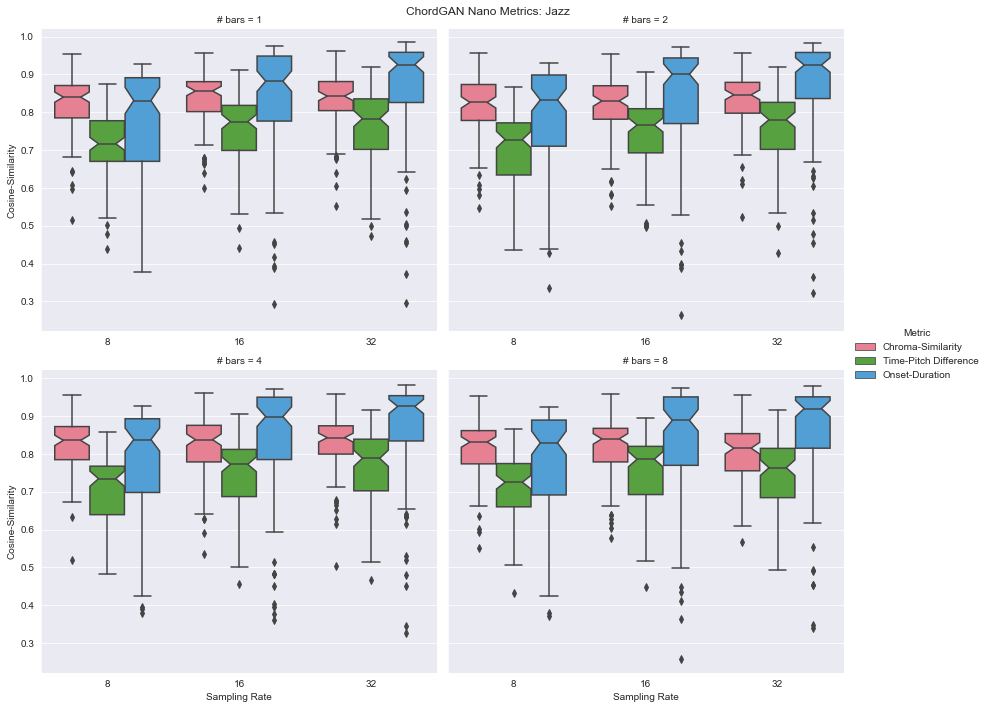

In [ ]:
plot_fs(nano_jazz, "Jazz")

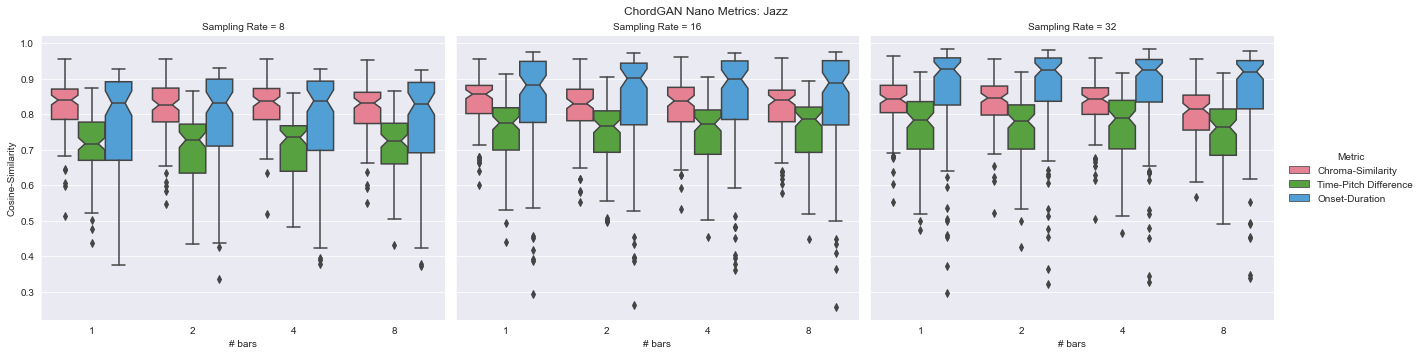

In [10]:
plot_n_bars(nano_jazz, "Jazz")

### Pop

In [30]:
get_summary(nano_df, "pop")

Sampling Rate             8                      16                      32  \
# bars                    1     2     4     8     1     2     4     8     1   
Chroma-Similarity     0.727 0.721 0.702 0.711 0.740 0.728 0.729 0.707 0.751   
Onset-Duration        0.792 0.793 0.792 0.797 0.832 0.827 0.832 0.836 0.888   
Time-Pitch Difference 0.814 0.814 0.807 0.816 0.865 0.856 0.861 0.856 0.884   

Sampling Rate                            
# bars                    2     4     8  
Chroma-Similarity     0.749 0.732 0.734  
Onset-Duration        0.884 0.884 0.889  
Time-Pitch Difference 0.882 0.879 0.884

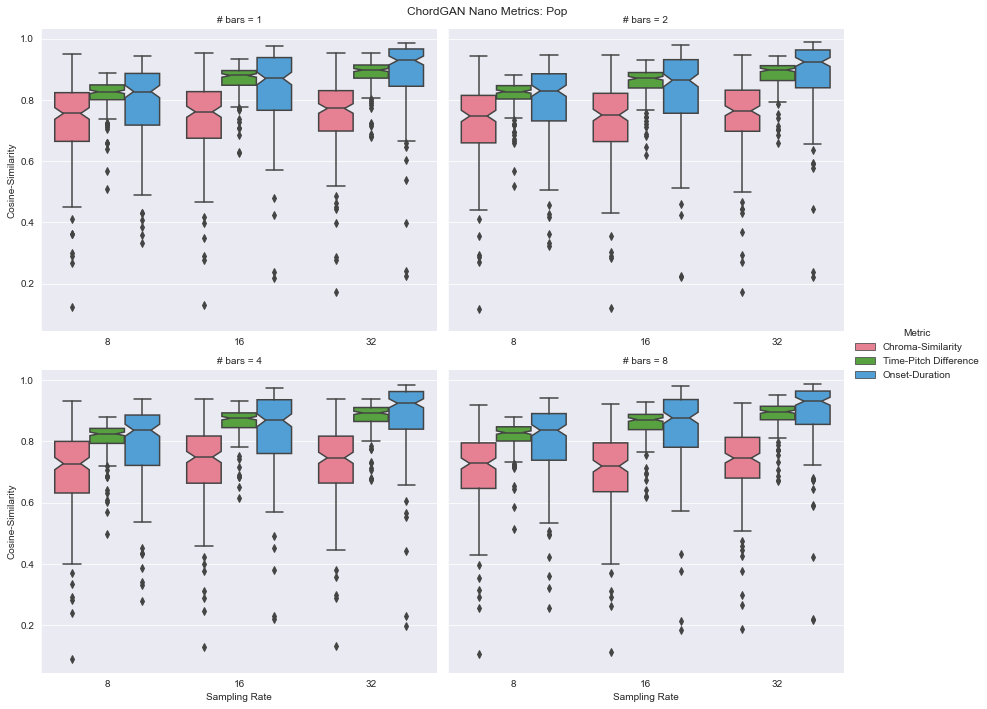

In [31]:
plot_fs(nano_pop, "Pop")

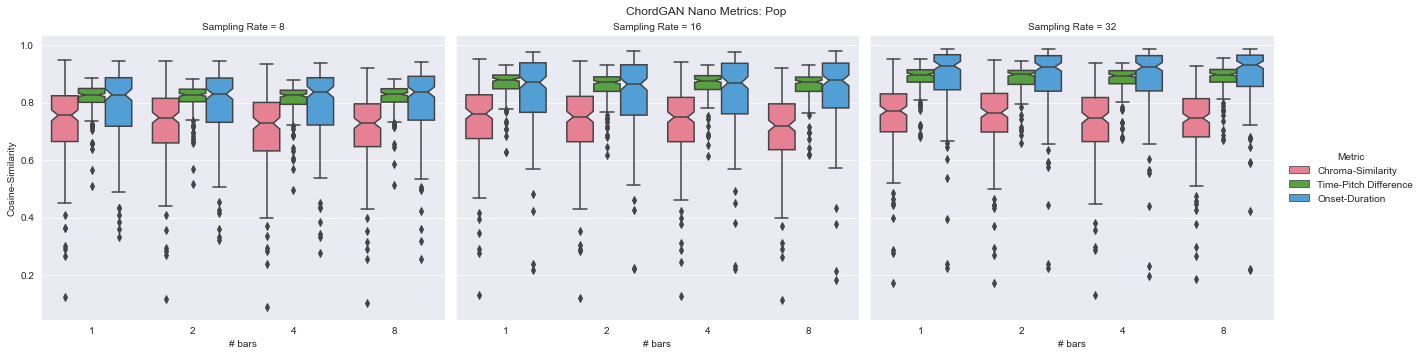

In [32]:
plot_n_bars(nano_pop, "Pop")

## Tonnetz

In [14]:
def plot_tonnetz(df, model):
    fig, ax = plt.subplots(figsize=(20, 7))
    palette = sns.color_palette("tab10", 4)

    ax = sns.boxplot(
        x="model_name",
        y="value",
        # hue="metric",
        data=df,
        ax=ax,
        notch=True,
        palette=palette,
    )
    ax.set_title(f"ChordGAN Tonnetz distance results ({model})")
    ax.set_xlabel("Model")
    ax.set_ylabel("Cosine Similarity")
    plt.show()

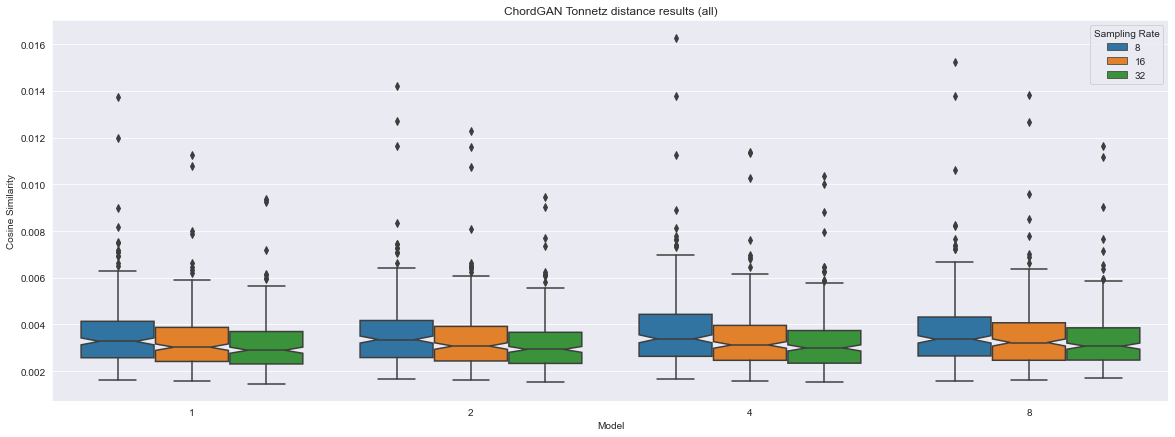

In [36]:
fig, ax = plt.subplots(figsize=(20, 7))
palette = sns.color_palette("tab10", 3)

ax = sns.boxplot(
    x="# bars",
    y="value",
    hue="Sampling Rate",
    data=tonnetz_df,
    ax=ax,
    notch=True,
    palette=palette,
)
ax.set_title(f"ChordGAN Tonnetz distance results (all)")
ax.set_xlabel("Model")
ax.set_ylabel("Cosine Similarity")
plt.show()

### Individual

In [37]:
tonnetz_jazz = tonnetz_df[tonnetz_df["model_name"].str.contains("jazz")]
tonnetz_pop = tonnetz_df[tonnetz_df["model_name"].str.contains("pop")]

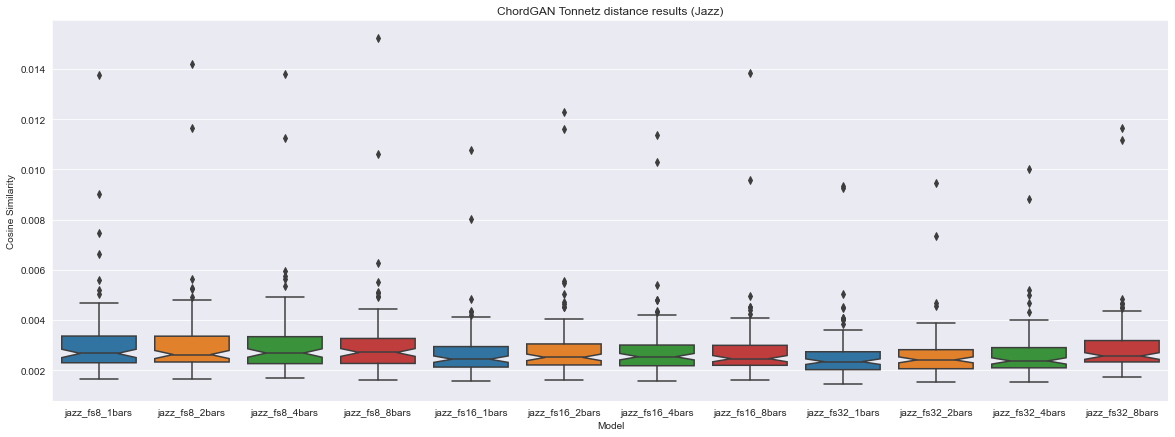

In [38]:
plot_tonnetz(tonnetz_jazz, "Jazz")

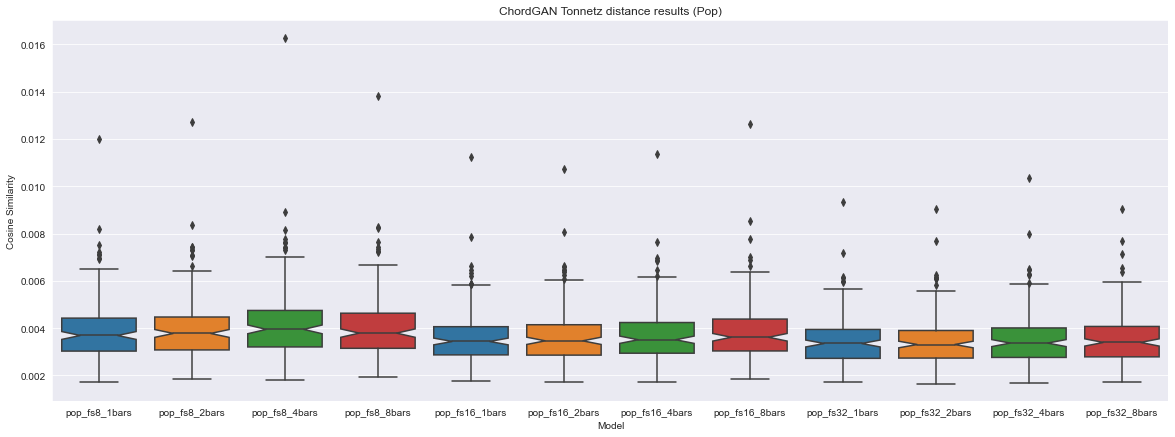

In [39]:
plot_tonnetz(tonnetz_pop, "Pop")

# Macro

In [18]:
def plot_macro(df, model):
    fig, ax = plt.subplots(figsize=(25, 10))
    palette = sns.color_palette("tab10", 3)

    ax = sns.barplot(
        x="model_name", y="value", hue="Metric", data=df, ec="k", lw=1, palette=palette,
    )
    autolabel(ax, orient="v", fmt="{:.2%}", xytext=(1, 1), size=13)
    # ax.legend(loc="lower center")
    ax.set_title(f"ChordGAN Macro average ({model})")
    ax.set_xlabel("Model")
    ax.set_ylabel("mean(cosine similarity)")
    plt.show()


mmap = {
    "macro_time_pitch_diff": "Time-Pitch Difference",
    "macro_onset_duration": "Onset-Duration",
}
macro_df["Metric"] = macro_df["metric"].replace(mmap)

macro_jazz = macro_df[macro_df["model_name"].str.contains("jazz")]
macro_pop = macro_df[macro_df["model_name"].str.contains("pop")]

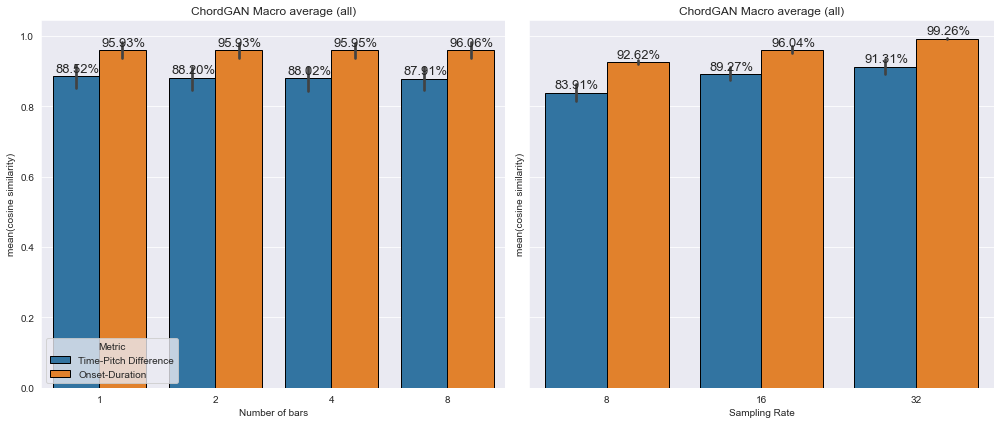

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
palette = sns.color_palette("tab10", 3)

ax1 = sns.barplot(
    x="# bars",
    y="value",
    hue="Metric",
    data=macro_df,
    ec="k",
    lw=1,
    palette=palette,
    ax=ax1,
)
autolabel(ax1, orient="v", fmt="{:.2%}", xytext=(1, 1), size=13)
ax1.set_title(f"ChordGAN Macro average (all)")
ax1.set_xlabel("Number of bars")
ax1.set_ylabel("mean(cosine similarity)")

ax2 = sns.barplot(
    x="Sampling Rate",
    y="value",
    hue="Metric",
    data=macro_df,
    ec="k",
    lw=1,
    palette=palette,
    ax=ax2,
)
ax2.legend().remove()
autolabel(ax2, orient="v", fmt="{:.2%}", xytext=(1, 1), size=13)
ax2.set_title(f"ChordGAN Macro average (all)")
ax2.set_xlabel("Sampling Rate")
ax2.set_ylabel("mean(cosine similarity)")

fig.tight_layout()
plt.show()

### Individual

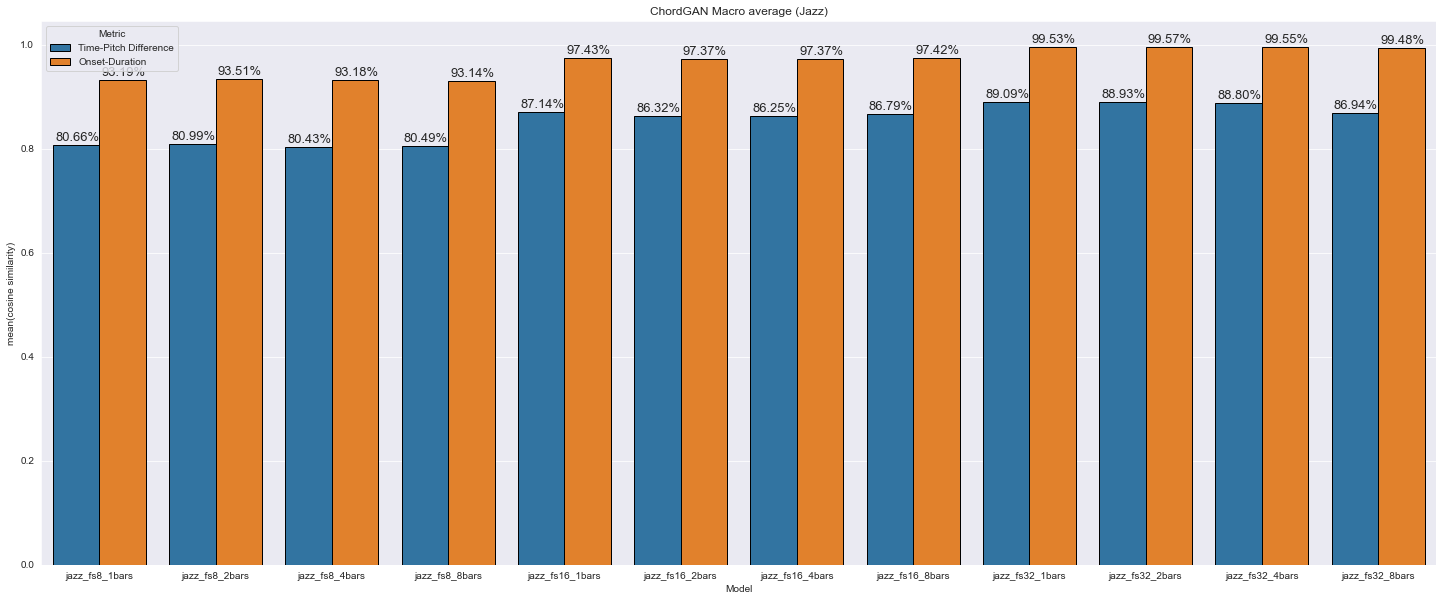

In [19]:
plot_macro(macro_jazz, "Jazz")

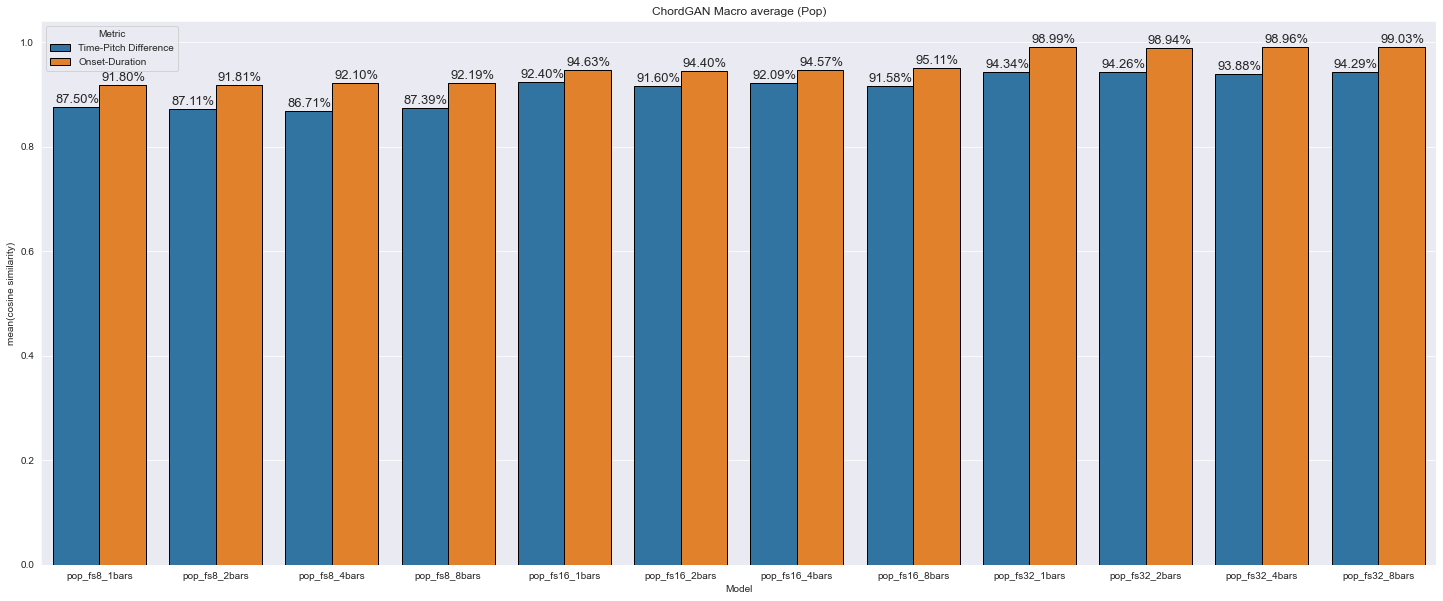

In [20]:
plot_macro(macro_pop, "Pop")